In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage
from scipy.optimize import least_squares
from skimage.draw import draw
from scipy import interpolate
import copy
import pickle

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [6]:
def calc_model_rms(avg_psd, mdl_set):
    delta_k = avg_psd.delta_k
    npix_diam = avg_psd.npix_diam
    # build the k-map
    cen = int(npix_diam/2)
    if npix_diam%2 == 0:
        ky, kx = np.ogrid[-cen:cen, -cen:cen]
    else:
        ky, kx = np.ogrid[-cen:cen+1, -cen:cen+1]
    ky = ky*delta_k
    kx = kx*delta_k
    k_map = np.sqrt(kx**2 + ky**2)
    
    # calculate the PSD
    psd_mdl = np.zeros_like(k_map.value)
    for n in range(0, len(mdl_set)):
        psd_parm = [mdl_set[n].alpha, mdl_set[n].beta, mdl_set[n].L0, mdl_set[n].lo, mdl_set[n].bsr]
        nmdl_psd = psd.model_full(k=k_map, psd_parm=psd_parm).value * mdl_set[n].psd_weight
        psd_mdl = psd_mdl + nmdl_psd
    psd_sum = psd_mdl * avg_psd.psd_radial_cal.unit
    
    # with the PSD calculated, do the RMS
    k_tgt_lim = [avg_psd.k_min, avg_psd.k_max]
    psd_rms = psd.do_psd_rms(psd_data=psd_sum, delta_k=delta_k, 
                             k_tgt_lim=k_tgt_lim, print_rms=False, print_kloc=False)
    return psd_rms


def plot_model2(mdl_set, model_sum, err_ratio, avg_psd, opt_parms):
    k_radial = avg_psd.k_radial.value
    psd_radial = avg_psd.psd_radial_cal.value
    k_range_mdl = mdl_set[0].k_range.value
    
    mdl_rms = calc_model_rms(avg_psd, mdl_set)
    
    color_list=['r', 'b','y', 'g']
    anno_opts = dict(xy=(0.1, .9), xycoords='axes fraction',
                     va='center', ha='center')

    plt.figure(figsize=[14,9],dpi=100)
    gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
    ax0 = plt.subplot(gs[0])  
    ax0.loglog(k_radial, psd_radial, 'k', linewidth=3, label='Avg PSD (PTT, all steps)\nRMS={0:.3f}'.format(avg_psd.rms_tot))
    for j in range(0, len(mdl_set)):
        if mdl_set[j].psd_weight != 0: 
            plt_label = '{0}: {1}={2:.3f}, {3}={4:.5f}\n'.format(r'$r_{0}$'.format(mdl_set[j].region_num),
                                                                 r'$\alpha$', mdl_set[j].alpha, 
                                                                 r'$\beta$', mdl_set[j].beta.value)
            plt_label = plt_label + '{0}={1:.1f}, {2}={3:.2f}, {4}={5:.1e}A\n'.format(r'$L_{0}$',mdl_set[j].L0, 
                                                                                       r'$l_{0}$', mdl_set[j].lo, 
                                                                                       r'$\sigma_{sr}$', mdl_set[j].rms_sr.to(u.angstrom).value)
            plt_label = plt_label + '{0}={1:.2f}'.format(r'$a_{0}$'.format(j), mdl_set[j].psd_weight)
            ax0.loglog(mdl_set[j].k_range.value, mdl_set[j].psd_full_scaled.value, color_list[j]+':', linewidth=1.5,
                       label=plt_label)
            # draw in the color box
            ax0.axvspan(k_radial[mdl_set[j].i_start], k_radial[mdl_set[j].i_end], facecolor=color_list[j], alpha=0.1)
    mdl_sum_text = 'model sum {0}\nRMS={1:.3f}'.format(r'$\Sigma a_{n}r_{n}$', mdl_rms)
    ax0.loglog(k_range_mdl, model_sum.value, linewidth=2.5, label=mdl_sum_text)
    ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax0.set_ylim(bottom=1e-5)
    ax0.set_ylabel('PSD ({0})'.format(mdl_set[0].psd_full.unit))
    ax0.legend(prop={'size':8})#,loc='center left', bbox_to_anchor=(1, 0.5))
    ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): fm {0}, {1}% CA'.format(opt_parms['label'], opt_parms['ca']))
    
    #avg_err = np.mean(np.abs(err_ratio))
    ax1 = plt.subplot(gs[1])
    ax1.semilogx(k_radial, err_ratio)
    ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k')
    ax1.set_ylim(top=1, bottom=-1)
    ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
    ax1.set_ylabel('log(ratio error)')
    ax1.set_xlabel('Spatial Frequency [{0}]'.format(mdl_set[0].k_range.unit))
    #ax1.annotate('Mean abs error %: {0:.4}%'.format(avg_err), **anno_opts)

    plt.tight_layout()

In [3]:
%%time
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'diam_ca100': 50*u.mm,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm,
             'label':'2in'}

nt_ptt = 3
psd_folder = 'zygo_data/flat_mirrors/mvls_psd/'

# open the file
fileloc = 'lspsd_fm_{0}_avg_z{1}.fits'.format(opt_parms['label'], nt_ptt)
psd_fits = fits.open(psd_folder+fileloc)[0]
psd_avg = psd_fits.data * (u.nm*u.mm)**2
psd_hdr = psd_fits.header
opt_parms['dk'] = psd_hdr['delta_k']/u.mm
opt_parms['diam_ca'] = psd_hdr['diam_ca']*u.mm
opt_parms['diam_pix'] = psd_hdr['diam_pix']
opt_parms['wavelen'] = psd_hdr['wavelen'] * u.m

# calculate the radial PSD data
avg_psd = psd.surfPSD(surf_name='average PSD')
avg_psd.load_psd(psd_data=psd_avg, psd_type='cal')
avg_psd.load_psd_parameters(diam_ca=opt_parms['diam_ca'], npix_diam=opt_parms['diam_pix'],
                            wavelen=opt_parms['wavelen'], delta_k=opt_parms['dk'])
avg_psd.calc_psd_radial(ring_width=opt_parms['ring_width'])
avg_psd.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                     pwr_opt=avg_psd.psd_cal, print_rms=False, print_kloc=False)

CPU times: user 317 ms, sys: 11.9 ms, total: 329 ms
Wall time: 330 ms


In [4]:
%%time
ist = [0, 4, 19]#, 55]
iend = [ist[1], ist[2], len(avg_psd.k_radial)-15]
rms_sr = [0.0005*u.nm, 0.0005*u.nm, 0.08*u.nm]
psd_weight = [1.0, 1.0, 1.0]
k_limit = [np.amin(avg_psd.k_radial)/10, np.amax(avg_psd.k_radial)*10]
mdl_set = []
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=avg_psd)
    mdl.calc_psd_parm(rms_sr=rms_sr[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=opt_parms['dk']*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum evaluation
ms = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms.calc_error()
ms.calc_psd_rms()

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=avg_psd)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

CPU times: user 6.31 s, sys: 63.2 ms, total: 6.37 s
Wall time: 3.37 s


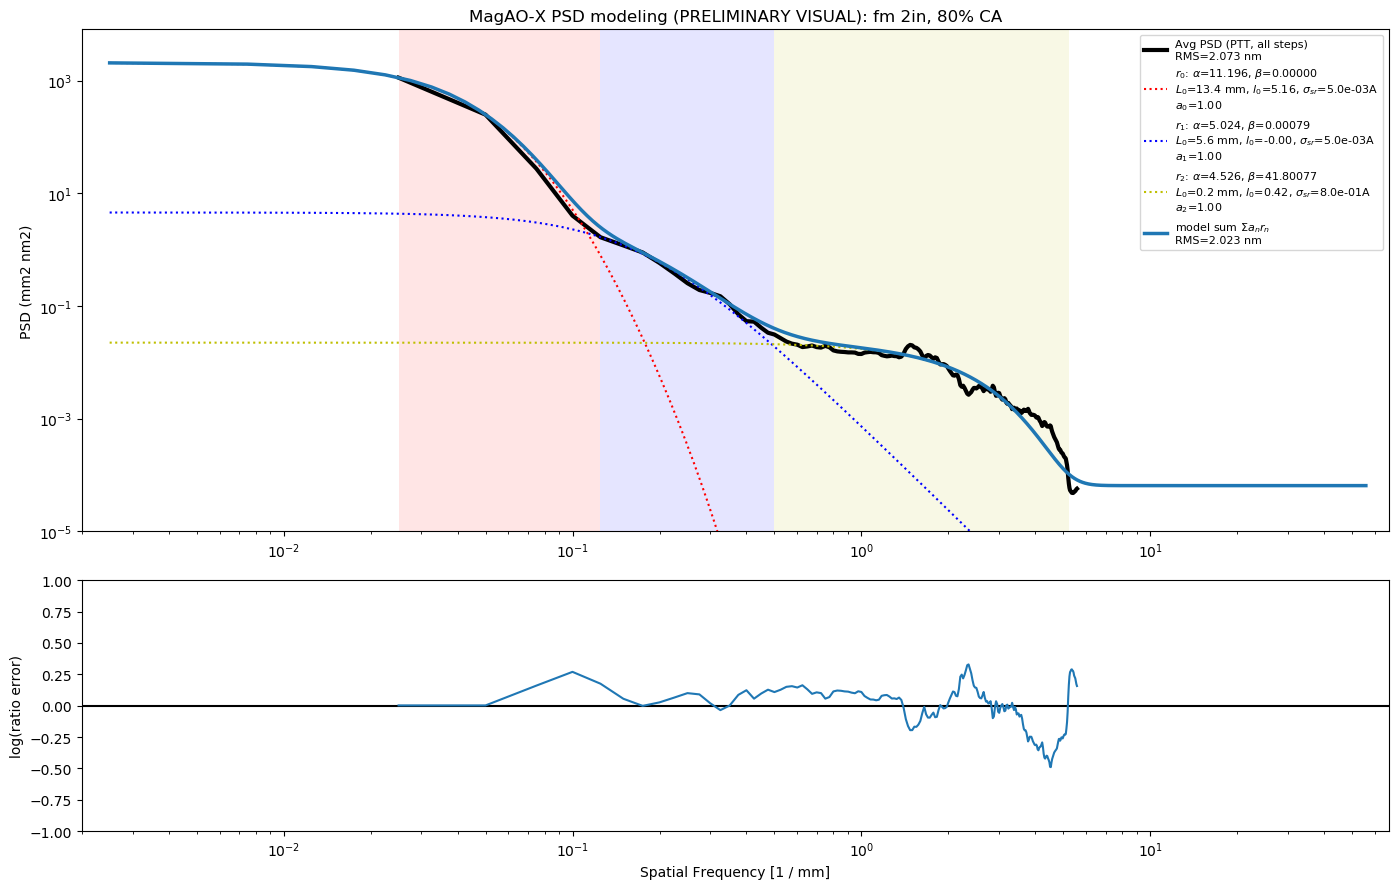

In [7]:
mdl_sum = ms.psd_radial_sum
err_ratio = ms.error
comb_model = ms.psd_radial_sum_data
plot_model2(mdl_set, mdl_sum, err_ratio, avg_psd, opt_parms)

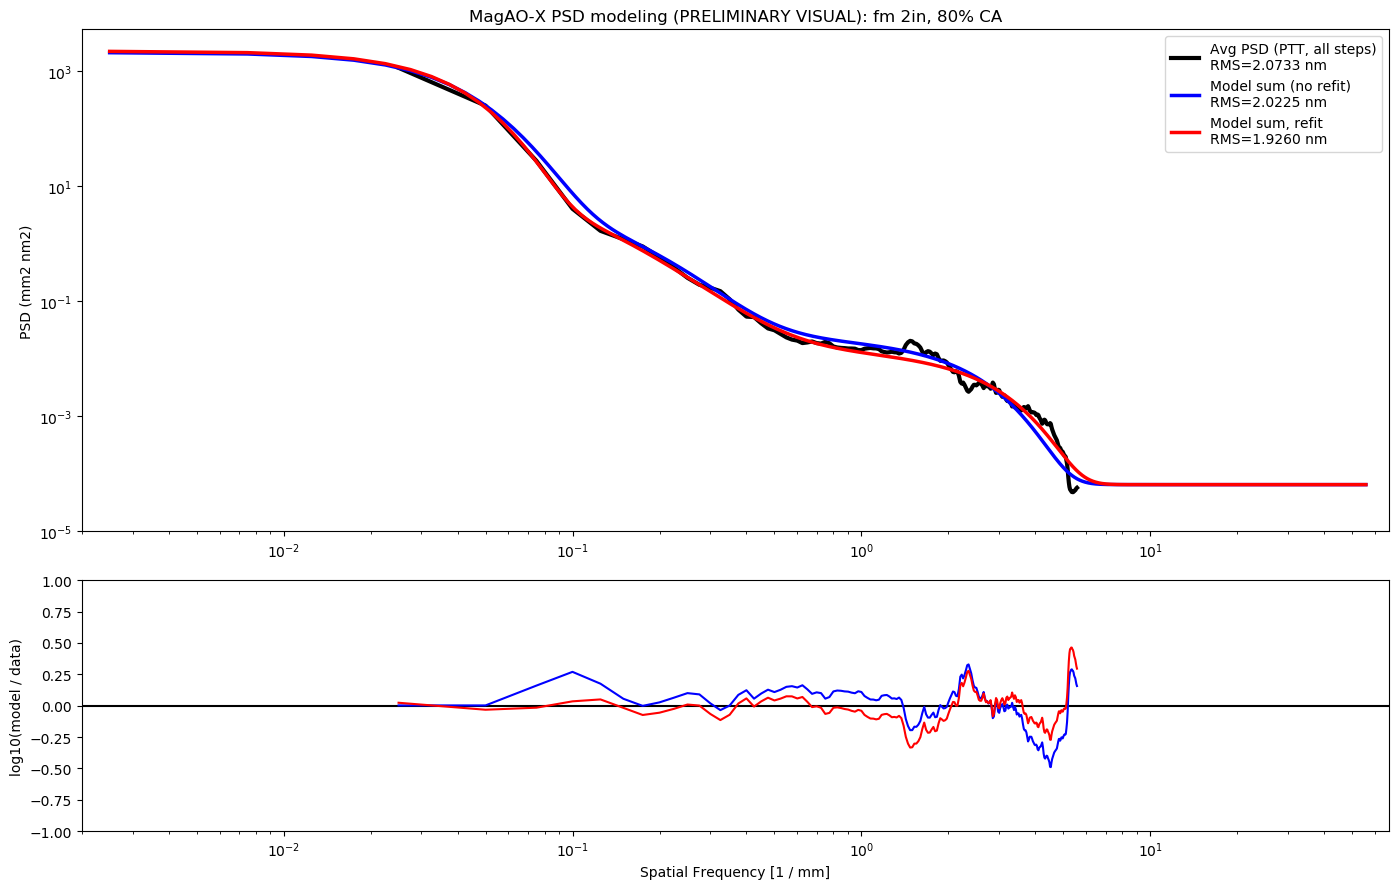

In [6]:
k_radial = avg_psd.k_radial.value
psd_radial = avg_psd.psd_radial_cal.value
k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[14,9],dpi=100)
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[4,2])
ax0 = plt.subplot(gs[0])  
ax0.loglog(k_radial, psd_radial, 'k', linewidth=3, label='Avg PSD (PTT, all steps)\nRMS={0:.4f}'.format(avg_psd.rms_tot))
ax0.loglog(k_range_mdl, ms.psd_radial_sum.value, 'b', linewidth=2.5, label='Model sum (no refit)\nRMS={0:.4f}'.format(ms.psd_rms_sum))
ax0.loglog(k_range_mdl, ms_refit.psd_radial_sum.value, 'r', linewidth=2.5, label='Model sum, refit\nRMS={0:.4f}'.format(ms_refit.psd_rms_sum))
ax0.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax0.set_ylim(bottom=1e-5)
ax0.set_ylabel('PSD ({0})'.format(ms.psd_radial_sum.unit))
ax0.legend(prop={'size':10})#,loc='center left', bbox_to_anchor=(1, 0.5))
ax0.set_title('MagAO-X PSD modeling (PRELIMINARY VISUAL): fm {0}, {1}% CA'.format(opt_parms['label'], opt_parms['ca']))

#avg_err = np.mean(np.abs(err_ratio))
ax1 = plt.subplot(gs[1])
ax1.semilogx(k_radial, ms.error, 'b')
ax1.semilogx(k_radial, ms_refit.error, 'r')
ax1.hlines(y=0, xmin=np.amin(k_range_mdl)*0.8, xmax=np.amax(k_range_mdl)*1.2, color='k')
ax1.set_ylim(top=1, bottom=-1)
ax1.set_xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
ax1.set_ylabel('log10(model / data)')
ax1.set_xlabel('Spatial Frequency [{0}]'.format(ms.k_radial_data.unit))
#ax1.annotate('Mean abs error %: {0:.4}%'.format(avg_err), **anno_opts)

plt.tight_layout()

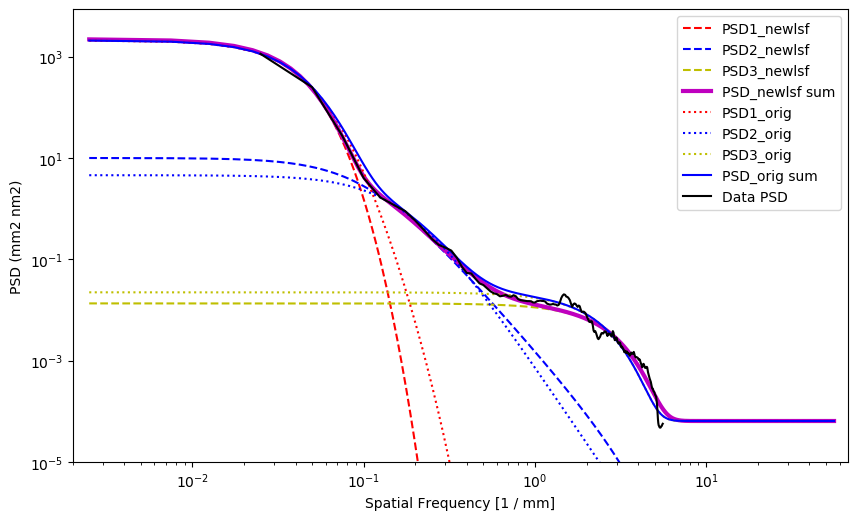

In [10]:
psd_1 = psd.model_full(k=mdl_set[0].k_range, psd_parm=ms_refit.psd_parm[0])
psd_2 = psd.model_full(k=mdl_set[0].k_range, psd_parm=ms_refit.psd_parm[1])
psd_3 = psd.model_full(k=mdl_set[0].k_range, psd_parm=ms_refit.psd_parm[2])
new_psd_tot = psd_1 + psd_2 + psd_3

k_range_mdl = mdl_set[0].k_range.value

plt.figure(figsize=[10,6], dpi=100)
plt.loglog(k_range_mdl, psd_1.value, 'r--', label='PSD1_newlsf')
plt.loglog(k_range_mdl, psd_2.value, 'b--', label='PSD2_newlsf')
plt.loglog(k_range_mdl, psd_3.value, 'y--', label='PSD3_newlsf')
plt.loglog(k_range_mdl, new_psd_tot.value, 'm', linewidth=3, label='PSD_newlsf sum')
plt.loglog(mdl_set[0].k_range.value, mdl_set[0].psd_full_scaled.value, 'r:', label='PSD1_orig')
plt.loglog(mdl_set[1].k_range.value, mdl_set[1].psd_full_scaled.value, 'b:', label='PSD2_orig')
plt.loglog(mdl_set[2].k_range.value, mdl_set[2].psd_full_scaled.value, 'y:', label='PSD3_orig')
plt.loglog(k_range_mdl, mdl_sum.value, 'b', label='PSD_orig sum')
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='Data PSD')
#plt.loglog(avg_psd.k_radial.value, pk_sum, 'm', label='pk sum test')
plt.xlim(left=np.amin(k_range_mdl)*0.8, right=np.amax(k_range_mdl)*1.2)
plt.ylim(bottom=1e-5)
plt.ylabel('PSD ({0})'.format(mdl_set[0].psd_full.unit))
plt.xlabel('Spatial Frequency [{0}]'.format(mdl_set[0].k_range.unit))
plt.legend()

In [57]:
# ignore for now until the PSD model is complete
psd_parm = []
for j in range(0, len(mdl_set)):
    parameters = [mdl_set[j].alpha, mdl_set[j].beta, mdl_set[j].L0, mdl_set[j].lo, mdl_set[j].bsr]
    psd_parm.append(parameters)
    
psd_dict = {'psd_fm2in': psd_parm,
            'psd_fm2in_weight': psd_scl}
psd_dict

# save the directory as a pickle
#filename='/home/jhen/XWCL/code/MagAOX/PSD/psd_parms_{0}.pickle'.format(psd_setting['label'])
#with open(filename,'wb') as psd_parameter_file:
#    pickle.dump(psd_dict, psd_parameter_file, protocol=4)

{'psd_fm2in': [[3.637766582524299,
   <Quantity 0.00177531 nm2 / mm(1.637766582524299)>,
   <Quantity 60. mm>,
   0.8,
   <Quantity 2.52855864e-09 mm2 nm2>],
  [0.9441086723837852,
   <Quantity 0.01522741 mm(1.055891327616215) nm2>,
   <Quantity 90. mm>,
   0.3,
   <Quantity 1.01142346e-06 mm2 nm2>],
  [3.0830879912095117,
   <Quantity 0.06390909 nm2 / mm(1.0830879912095117)>,
   <Quantity 0.55 mm>,
   0.05,
   <Quantity 6.47311013e-05 mm2 nm2>]],
 'psd_fm2in_weight': [1.0, 0.6, 0.4]}